# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, datasets
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [2]:
# Parameters for data loading
num_workers = 0
batch_size = 50
valid_size = 0.2

# Convert data to torch.FloatTensor
transform = transforms.ToTensor()

# Choose the training and test datasets
train_data = datasets.MNIST(root='~\.pytorch\MNIST_data', train=True, download=False, transform=transform)
test_data = datasets.MNIST(root='~\.pytorch\MNIST_data', train=False, download=False, transform=transform)

In [3]:
# Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [4]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: C:\Users\mohamedelbeah\.pytorch\MNIST_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
valid_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: C:\Users\mohamedelbeah\.pytorch\MNIST_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_loader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: C:\Users\mohamedelbeah\.pytorch\MNIST_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
print("Samples in train_loader: \t{}".format(len(train_loader.sampler)))
print("Samples in valid_loader: \t{}".format(len(valid_loader.sampler)))
print("Samples in test_loader: \t{}".format(len(test_loader.sampler)))

Samples in train_loader: 	48000
Samples in valid_loader: 	12000
Samples in test_loader: 	10000


### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

In [8]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

In [9]:
images.shape

(50, 1, 28, 28)

In [10]:
labels

tensor([2, 5, 2, 5, 0, 5, 6, 2, 4, 9, 6, 8, 8, 5, 4, 0, 3, 0, 7, 3, 1, 2, 8, 3,
        7, 3, 9, 9, 8, 3, 6, 0, 3, 8, 9, 1, 1, 3, 0, 3, 7, 9, 6, 9, 8, 0, 1, 1,
        5, 4])

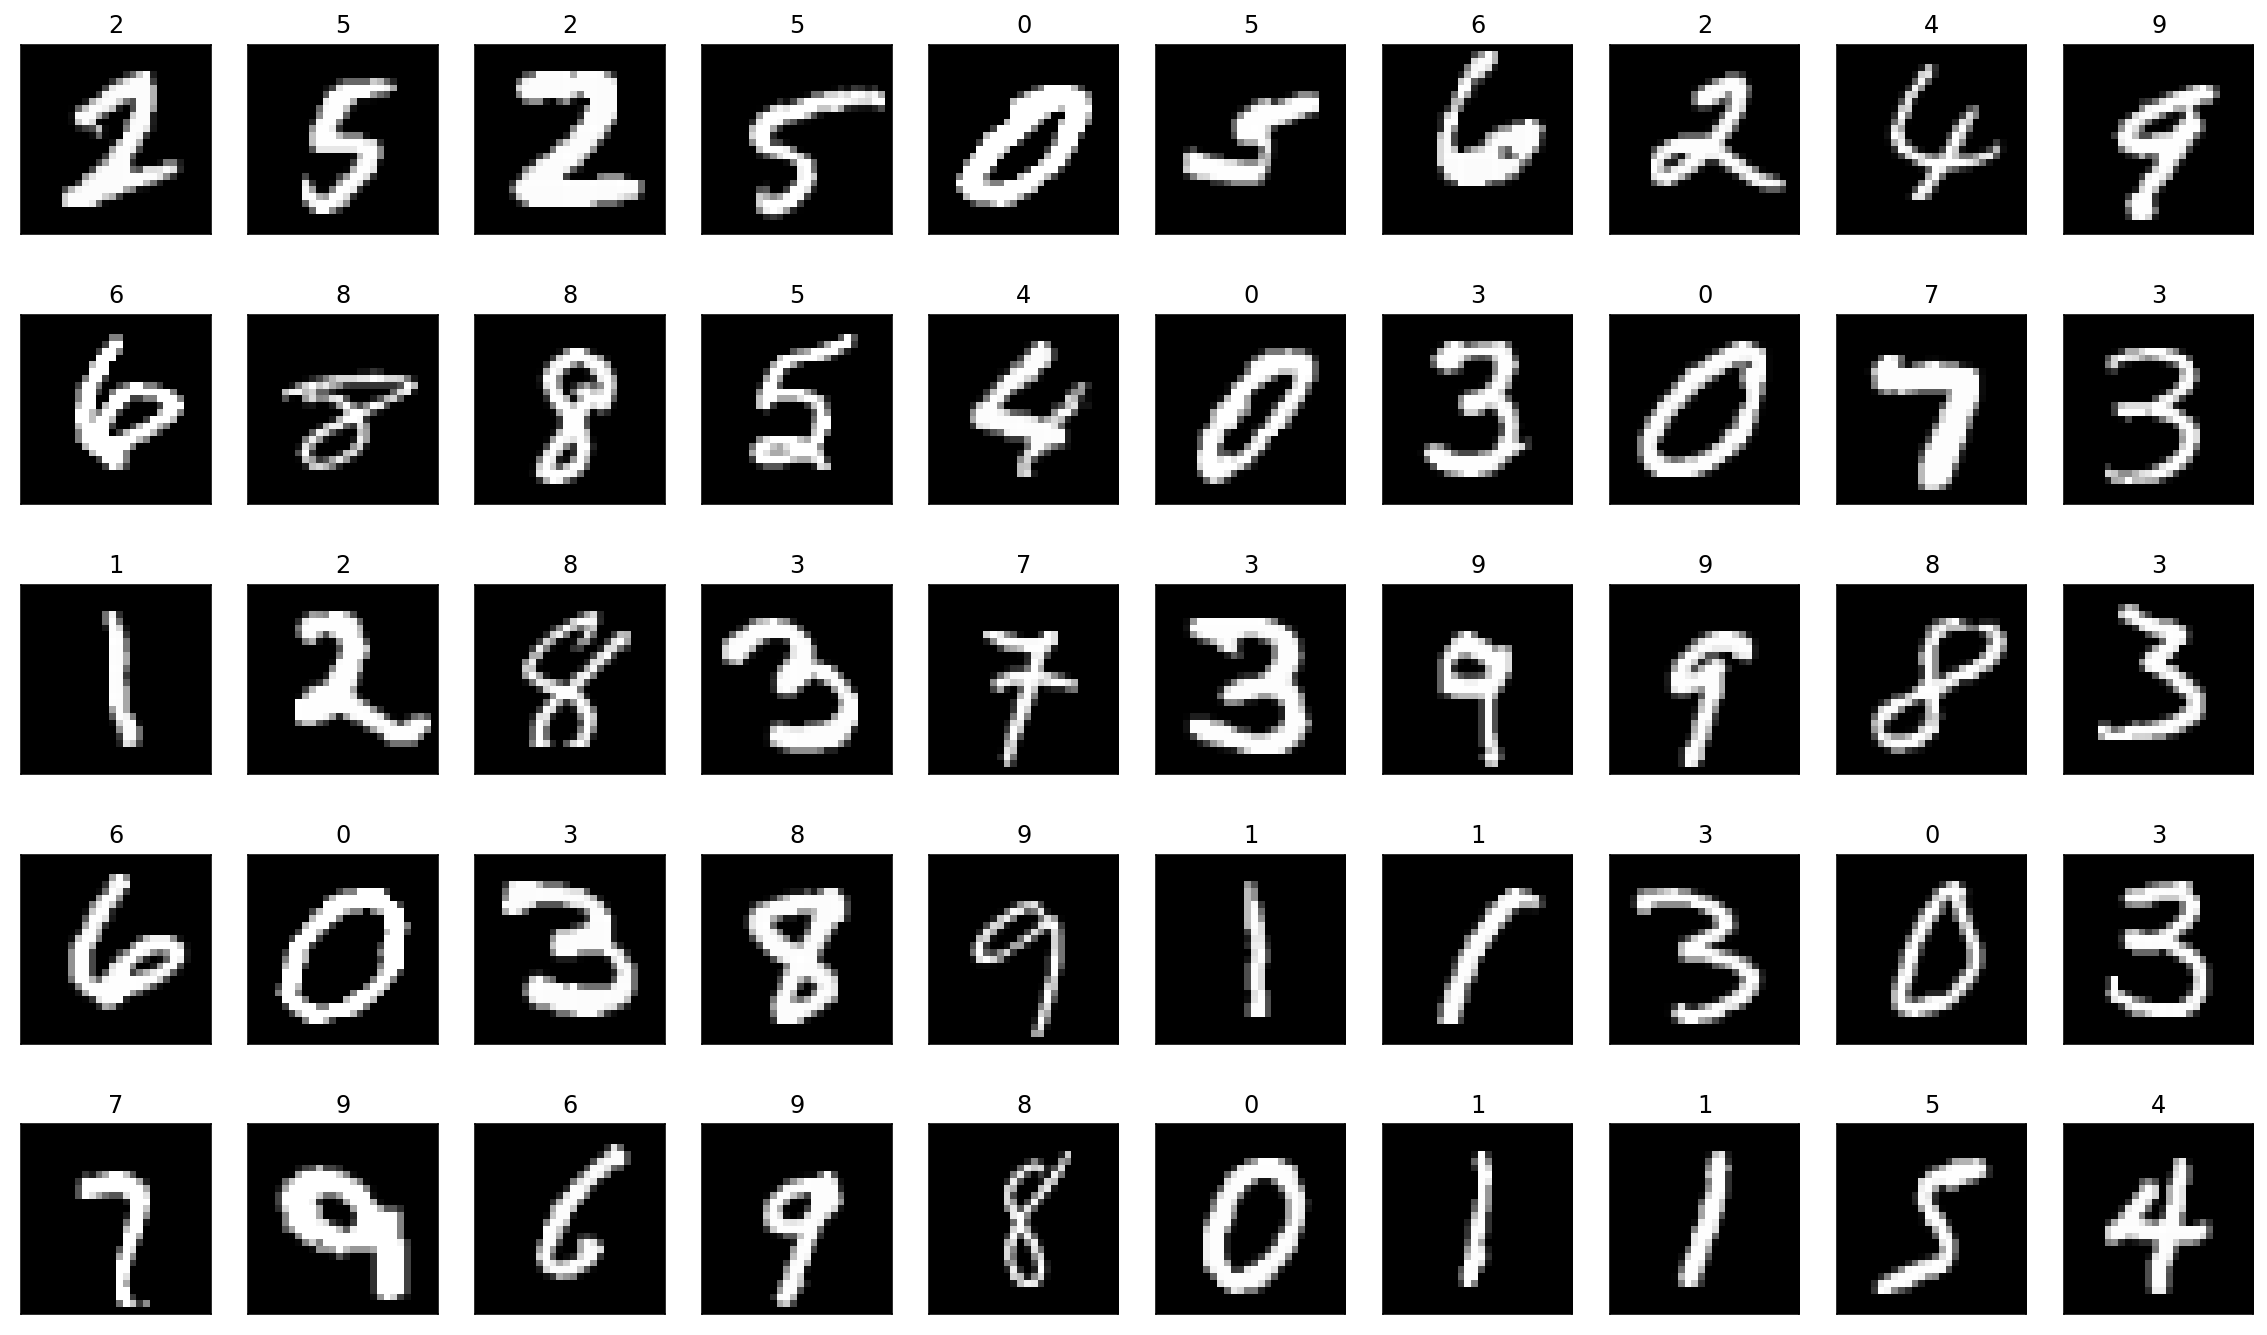

In [11]:
# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 12))

for idx in np.arange(50):
    ax = fig.add_subplot(5, 50/5, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

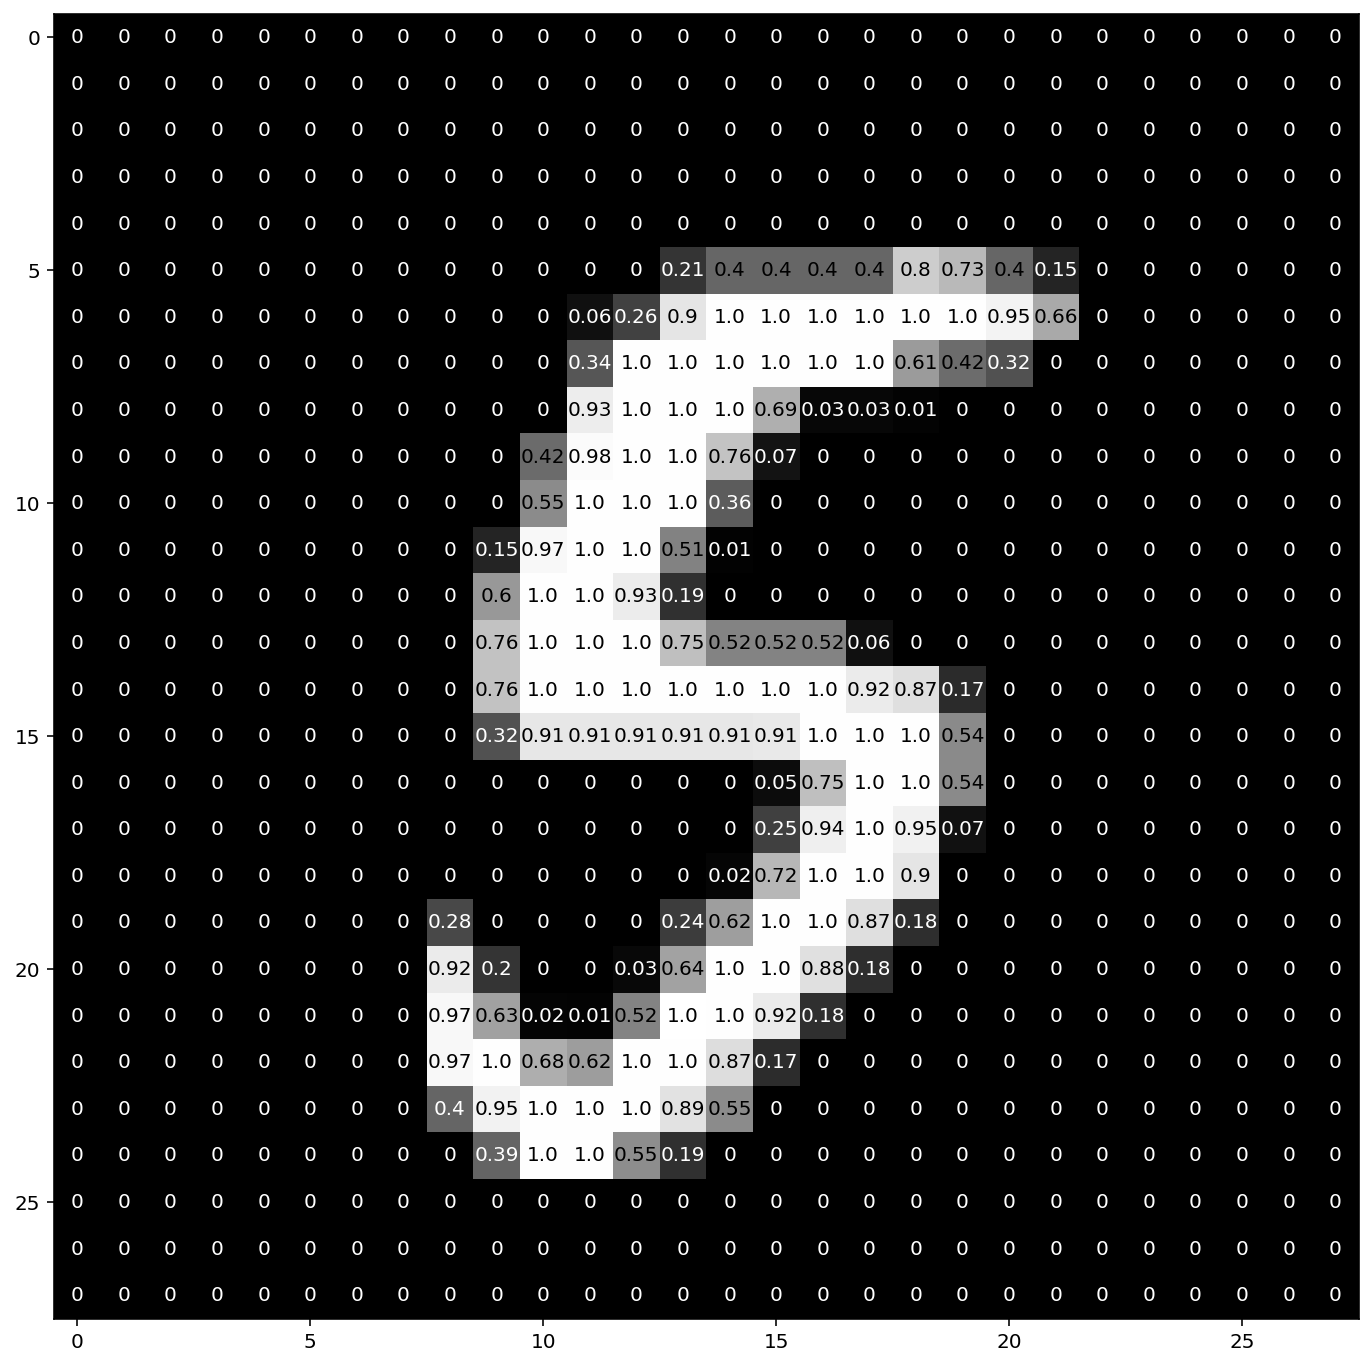

In [12]:
img = np.squeeze(images[1])

fig = plt.figure(figsize=(12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
height, width = img.shape
thresh = img.max()/2.5

for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This example uses dropout to avoid overfitting.

In [13]:
# Define the NN architecture
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.2):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super(Network, self).__init__()
        
        # Input to a hidden layer
        self.linears = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.linears.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        # output from hidden layers
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        # flatten image input
        x = x.view(-1, 784)
        
        for each in self.linears:
            x = self.dropout(F.relu(each(x)))
        
        x = self.output(x)
        
        return x

In [14]:
# Initialize the Network
model = Network(784, 10, [512, 512])
print(model)

Network(
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (output): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [15]:
# Specify loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.02)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 50 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [16]:
# Automatically use CUDA if it's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Moving the model to GPU if possible
model = model.to(device)

In [22]:
# Defining train function
def train(model, train_loader, valid_loader, criterion, optimizer, save_path, epochs=5):
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinit

    # Training the model
    train_losses, valid_losses = [], []

    for epoch in range(epochs):
        ###################
        #  Training Pass  #
        ###################
        train_loss = 0.0
        for images, labels in train_loader:
        
            # Move images & labels to GPU
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            scores = model.forward(images)
            loss = criterion(scores, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
    
        ###################
        # Validation Pass #
        ###################
        valid_loss = 0.0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            # set model to evaluation mode
            model.eval()
            
            for images, labels in valid_loader:
                # Move images & labels to GPU
                images, labels = images.to(device), labels.to(device)
            
                scores = model.forward(images)
                loss = criterion(scores, labels)
                valid_loss += loss.item()   
    
        # Calculate average loss over an epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)
    
        # Append train and valid losses
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
    
        # Print training statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
    
        # Save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # Saving losses
    losses = {'train_losses': train_losses, 'valid_losses': valid_losses}
    
    # set model back to train mode
    model.train()
        
    return losses

In [18]:
# Training the model with 50 epochs
losses = train(model, train_loader, valid_loader, criterion, optimizer, save_path='model.pth', epochs=50)

Epoch: 1 	Training Loss: 1.080979 	Validation Loss: 0.412914
Validation loss decreased (inf --> 0.412914).  Saving model ...
Epoch: 2 	Training Loss: 0.354445 	Validation Loss: 0.311990
Validation loss decreased (0.412914 --> 0.311990).  Saving model ...
Epoch: 3 	Training Loss: 0.287615 	Validation Loss: 0.269006
Validation loss decreased (0.311990 --> 0.269006).  Saving model ...
Epoch: 4 	Training Loss: 0.246299 	Validation Loss: 0.239780
Validation loss decreased (0.269006 --> 0.239780).  Saving model ...
Epoch: 5 	Training Loss: 0.214340 	Validation Loss: 0.210660
Validation loss decreased (0.239780 --> 0.210660).  Saving model ...
Epoch: 6 	Training Loss: 0.187866 	Validation Loss: 0.186690
Validation loss decreased (0.210660 --> 0.186690).  Saving model ...
Epoch: 7 	Training Loss: 0.166244 	Validation Loss: 0.171621
Validation loss decreased (0.186690 --> 0.171621).  Saving model ...
Epoch: 8 	Training Loss: 0.149070 	Validation Loss: 0.158464
Validation loss decreased (0.17162

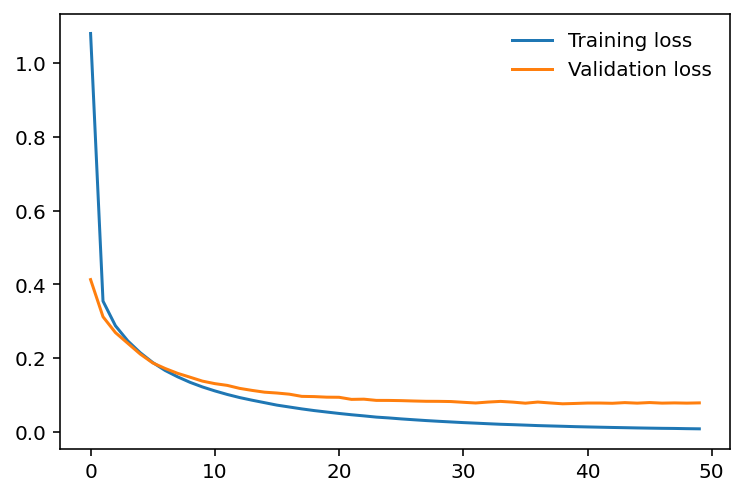

In [19]:
# Displaying Training and Validation losses
train_losses = losses['train_losses']
valid_losses = losses['valid_losses']

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False);

###  Load the Model with the Lowest Validation Loss

In [20]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [19]:
# Defining test function
def test(model, test_loader):
    # Initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    # set model to evaluation mode
    model.eval()

    for images, labels in test_loader:
        # Move images & labels to GPU
        images, labels = images.to(device), labels.to(device)

        scores = model.forward(images)
        loss = criterion(scores, labels)
        test_loss += loss.item()
        
        # Compare predictions to true labels
        top_p, top_class = torch.max(scores, 1)
        correct = np.squeeze(top_class.eq(labels.data.view_as(top_class)))
        
        # Calculate test accuracy for each object class
        for i in range(len(labels)):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1


    # Calculate and print avg test loss
    test_loss = test_loss/len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i],
                                                             np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                          np.sum(class_correct), np.sum(class_total)))

In [22]:
# Testing the model
test(model, test_loader)

Test Loss: 0.066527

Test Accuracy of     0: 98% (968/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 97% (1011/1032)
Test Accuracy of     3: 98% (992/1010)
Test Accuracy of     4: 98% (963/982)
Test Accuracy of     5: 97% (868/892)
Test Accuracy of     6: 97% (933/958)
Test Accuracy of     7: 97% (1000/1028)
Test Accuracy of     8: 97% (952/974)
Test Accuracy of     9: 97% (980/1009)

Test Accuracy (Overall): 97% (9793/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

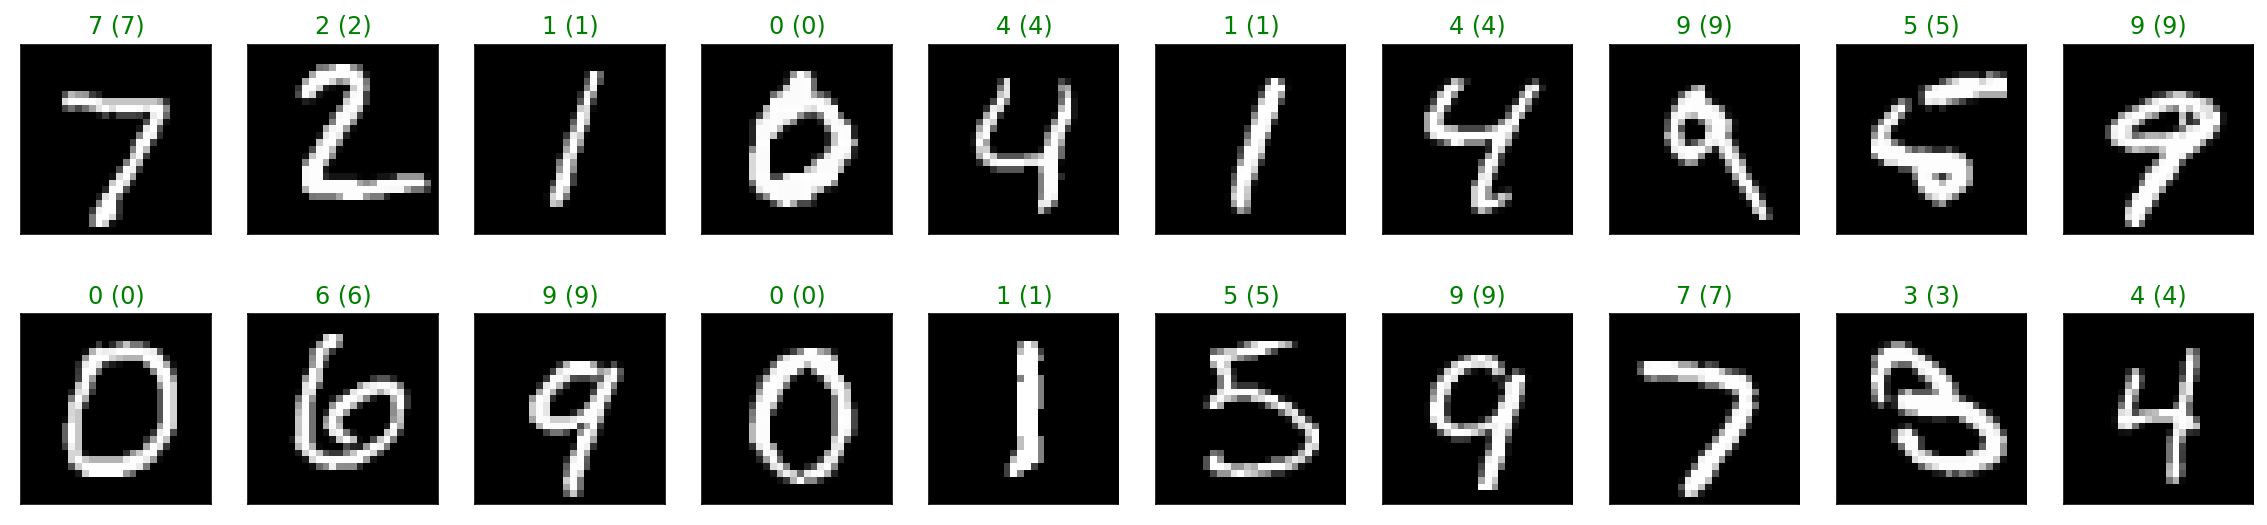

In [23]:
# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# Move images & labels to GPU
images, labels = images.to(device), labels.to(device)

# Get sample outputs
scores = model.forward(images)

# Compare predictions to true labels
top_p, top_class = torch.max(scores, 1)

# Prep images for display
images = images.cpu().numpy()
labels = labels.cpu().numpy()
top_class = top_class.cpu().numpy()

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 12))
for idx in np.arange(20):
    ax = fig.add_subplot(5, 50/5, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(top_class[idx].item()), str(labels[idx].item())),
                 color=("green" if top_class[idx]==labels[idx] else "red"))

---
## Test Different Network Architectures

In [20]:
hidden_layers = [[500],
                 [1000, 500],
                 [1500, 1000, 500],
                 [2000, 1500, 1000, 500],
                 [2500, 2000, 1500, 1000, 500]]

In [21]:
for i in range(len(hidden_layers)):
    new_model = Network(784, 10, hidden_layers[i])
    
    # Moving the model to GPU if possible
    new_model.to(device)
    
    # Specify loss function & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(new_model.parameters(), lr=0.02)
    
    # Training the model with 20 epochs
    print('****************************************************************************')
    print('Training model with layers: {}'.format([784, hidden_layers[i], 10]))
    save_path = 'model' + (i+1) *'_{}' + '.pth'
    save_path = save_path.format(*hidden_layers[i])
    losses = train(new_model, train_loader, valid_loader, criterion, optimizer, save_path, epochs=20)
    
    # Loading model with lowest validation loss
    new_model.load_state_dict(torch.load(save_path))
    
    # Testing the model
    test(new_model, test_loader)
    print('****************************************************************************')
    print('\n')

****************************************************************************
Training model with layers: [784, [500], 10]
Test Loss: 0.110837

Test Accuracy of     0: 98% (964/980)
Test Accuracy of     1: 98% (1117/1135)
Test Accuracy of     2: 97% (1003/1032)
Test Accuracy of     3: 96% (978/1010)
Test Accuracy of     4: 96% (952/982)
Test Accuracy of     5: 96% (860/892)
Test Accuracy of     6: 96% (926/958)
Test Accuracy of     7: 96% (989/1028)
Test Accuracy of     8: 95% (932/974)
Test Accuracy of     9: 94% (952/1009)

Test Accuracy (Overall): 96% (9673/10000)
****************************************************************************


****************************************************************************
Training model with layers: [784, [1000, 500], 10]
Test Loss: 0.077772

Test Accuracy of     0: 98% (963/980)
Test Accuracy of     1: 98% (1122/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 98% (992/1010)
Test Accuracy of     4: 97% (958/982)
Test